In [1]:
# k-means clustering
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
NUM_VERTIPORTS = 2000
NUM_VERTIHUBS = 2000

In [3]:
df = pd.read_csv('data/Realtime/OpsLimits/zone17_lat_long.csv')
df = df.drop(columns=['Unnamed: 0'])
df

,zone,lat,long
0,4,41.894749,-87.630593
1,3,41.894694,-87.635477
2,11,41.891098,-87.630498
3,10,41.891045,-87.635384
4,2,41.894628,-87.640390
...,...,...,...
3627,3628,42.799750,-88.483873
3628,3631,42.820926,-88.336315
3629,3632,42.821120,-88.395137
3630,3629,42.777493,-88.337102


In [4]:
def k_means(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(data[:,[0,1]])
    labels = kmeans.labels_
    plt.scatter(data[:,0], data[:,1], c=['tab:blue' for i in labels], alpha=.5, label='Zone', s=20)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=50,c='tab:orange', label='Vertiport - Centroid')
    plt.ylabel("Latitude")
    plt.xlabel("Longitude")
    plt.legend()
    plt.title("K-Means Zone Clusters")
    plt.savefig('data/Realtime/OpsLimits/zones_to_towers_' + str(NUM_VERTIHUBS) + '.png', dpi=216)
    plt.show()
    return kmeans


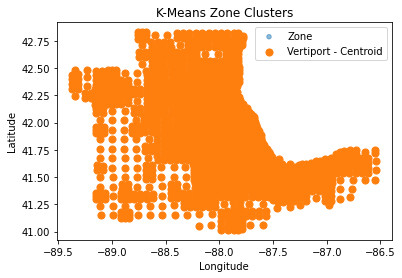

In [5]:
import copy
formatted_df = copy.deepcopy(df)
formatted_df['color'] = [float(0.5) for i in range(len(formatted_df['lat']))]
formatted_df = formatted_df[['long','lat','color']].to_numpy()
kmeans = k_means(formatted_df, NUM_VERTIPORTS)

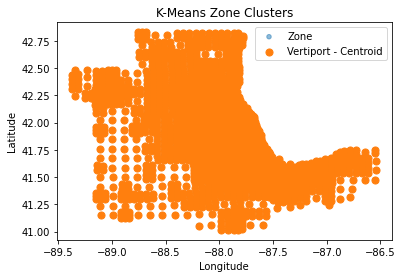

,vertiport,long,lat,vertihub
0,0,-88.077616,41.691089,1750
1,1,-88.335512,42.284315,136
2,2,-87.590294,41.736803,1962
3,3,-87.867464,42.013719,1767
4,4,-89.143889,42.128561,372
...,...,...,...,...
1995,1995,-87.906844,41.775018,1513
1996,1996,-87.897864,42.095067,1900
1997,1997,-87.568446,41.593811,248
1998,1998,-87.801232,41.536060,360


In [6]:
# cluster centers = tower, cluster these towers for determing rendezvous points
tower_locations = kmeans.cluster_centers_

vertihubs_to_vertiports = pd.DataFrame()
vertihubs_to_vertiports['vertiport'] = [i for i in range(NUM_VERTIPORTS)]

vertihubs_to_vertiports['long'] = copy.deepcopy(tower_locations[:,0])
vertihubs_to_vertiports['lat'] = copy.deepcopy(tower_locations[:,1])
vertihubs_to_vertiports['color'] = [.5 for i in range(len(vertihubs_to_vertiports['lat']))]

tower_locations_formatted = vertihubs_to_vertiports[['long','lat','color']].to_numpy()

vertiport_kmeans = k_means(tower_locations_formatted, NUM_VERTIHUBS)

vertihubs_to_vertiports['vertihub'] = vertiport_kmeans.labels_
vertihubs_to_vertiports.drop(columns='color', inplace=True)
vertihubs_to_vertiports.to_csv('data/Realtime/OpsLimits/vertiports_' + str(NUM_VERTIHUBS) + '.csv', index=False)
# these are actually vertihubs (orange) and vertiports (blue)
vertihubs_to_vertiports

In [7]:
# now that each zone is assigned to a vertiport, lets change our flights from zone->zone to vertiport->vertiport

# NOTE: THIS DATA SET IS NOT INCLUDED WITH THE REPOSITORY AS IT IS A LARGE FILE. Please contact me (joeymuffoletto10@gmail.com) or Dr. Natasha Neogi (natasha.a.neogi@nasa.gov)
trips_from_work = pd.read_csv('data/Realtime/OpsLimits/commute_trips_fr_work_hhincome_all_chicago_matlab.csv')
time = trips_from_work['time']



In [13]:
import datetime


TIME_RANGE_START = datetime.time(15,2,0)
TIME_RANGE_END = datetime.time(16, 2, 0)

In [14]:
# convert to datetime.time objects
trips_between_start_end = [] 
for row in trips_from_work.itertuples(index=False):
    as_datetime = datetime.datetime.fromisoformat(row[0]).time()
    if as_datetime >= TIME_RANGE_START and as_datetime <= TIME_RANGE_END:
        trips_between_start_end.append((as_datetime, row[1], row[2], 
                                        row[3], row[4]))
print(trips_between_start_end[0])



(datetime.time(15, 42), 42.596247144373706, -87.89523568177601, 42.567349400977, -87.93349620315571)


In [15]:
from math import cos, asin, sqrt, pi

# def dist(x1, y1, x2, y2):
#     return math.sqrt((y2-y1)**(y2-y1) + (x2-x1)**(x2-x1))
def ll_distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...   
    

In [16]:
# for these trips, convert their longlat origin and destination coordinate to the nearest tower

tower_locations = kmeans.cluster_centers_
# print(tower_locations)
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple', 'tab:brown', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_map = {i : color for i, color in enumerate(colors)}

frame = pd.DataFrame()
frame['long'] = copy.deepcopy(tower_locations[:,0])
frame['lat'] = copy.deepcopy(tower_locations[:,1])
frame['color'] = [.5 for i in range(len(frame['lat']))]

tower_to_rendezvous = frame
tower_to_rendezvous['tower'] = [i for i in range(NUM_VERTIPORTS)] 

formatted_trips = []
min_time = datetime.datetime.combine(datetime.date.min, min(trips_between_start_end)[0])
for trip in trips_between_start_end:
    time, origin_lat, origin_long, dest_lat, dest_long = trip
    origin = min([(ll_distance(origin_lat, origin_long, other_lat, other_long), tower) 
                  for other_lat, other_long, tower in 
                  zip(tower_to_rendezvous['lat'],
                    tower_to_rendezvous['long'],
                     tower_to_rendezvous['tower']
                     )
                 ])
    destination = min([(ll_distance(dest_lat, dest_long, other_lat, other_long), tower) 
                  for other_lat, other_long, tower in 
                  zip(tower_to_rendezvous['lat'],
                    tower_to_rendezvous['long'],
                     tower_to_rendezvous['tower']
                     )
                 ])
    normalized_time_in_seconds = (datetime.datetime.combine(datetime.date.min, time) - min_time).seconds
    origin_vertiport = origin[1]
    destination_vertiport = destination[1]
    origin_vertihub = vertihubs_to_vertiports['vertihub'][origin_vertiport]
    destination_vertihub = vertihubs_to_vertiports['vertihub'][destination_vertiport]

    formatted_trips.append((normalized_time_in_seconds, origin_vertihub, origin_vertiport, destination_vertihub, destination_vertiport)) # seconds from start time of simulation
# print (formatted_trips)

In [17]:
trips_df = pd.DataFrame(formatted_trips, columns=['Time', 'OriginVertihub','OriginVertiport', 'DestinationVertihub', 'DestinationVertiport'])
trips_df.to_csv('data/Realtime/OpsLimits/trips_' + str(NUM_VERTIHUBS) + '.csv', index=False)
trips_df

,Time,OriginVertihub,OriginVertiport,DestinationVertihub,DestinationVertiport
0,2400,915,148,1122,581
1,3540,1638,1928,1531,1900
2,1680,1868,162,1504,1724
3,2100,1152,1353,1539,1579
4,1860,603,1491,779,716
...,...,...,...,...,...
295689,1920,1986,459,952,977
295690,420,1024,1551,1729,328
295691,3360,1859,1240,1569,1742
295692,120,1622,902,1774,233
